# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import ast
import re
from timeit import default_timer as timer

C:\Users\dom\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [2]:
#Function that writes to csv
def saveData(x):
    x.to_csv('dataintermediate.csv',index=False)

In [3]:
#find any of specific substrings 
def substringExists(x,strlist):
    """if any of folling values appears return 1"""
    if any(re.findall('|'.join(strlist),x)):
        return 1
    return x

# Data preparation

### Read Data and select columns for Model

In [4]:
df=pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
#First I will use most commonsence properties that might influence the property Price
data=df[['status','private pool','baths','homeFacts','fireplace','schools','sqft','beds','state','stories','PrivatePool','propertyType','target']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   baths         270847 non-null  object
 3   homeFacts     377185 non-null  object
 4   fireplace     103115 non-null  object
 5   schools       377185 non-null  object
 6   sqft          336608 non-null  object
 7   beds          285903 non-null  object
 8   state         377185 non-null  object
 9   stories       226470 non-null  object
 10  PrivatePool   40311 non-null   object
 11  propertyType  342452 non-null  object
 12  target        374704 non-null  object
dtypes: object(13)
memory usage: 37.4+ MB


## HomeFacts

In [7]:
data['homeFacts']=data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])


In [8]:
#Get Labels for df columns
def getdata(x):
    Labels=list()
    for i in x:
        Labels.append(i['factLabel'])
    return Labels
Labels=getdata(data.homeFacts[1])
Labels

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [9]:
#Convert dictionaries per row to appropriate columns in df and extract all the values
for l in Labels:
    data[l]=data['homeFacts'].apply(lambda x: x[Labels.index(l)]['factValue']) 

In [10]:
saveData(data)


## Schools

In [11]:
data=pd.read_csv('dataintermediate.csv')
data['schools']=data['schools'].apply(lambda x: ast.literal_eval(x)[0])

In [12]:
#Extract rating list to schRating column
data['schRating']=data['schools'].apply(lambda x: [n for n in x['rating'] if n != 'NR']) 

In [13]:
def findrating(x):
    '''Function that makes an order in ratings and takes the maximum'''
    l=[0]
    for i in x:
        if (i.find('/')>-1 and i[:i.find('/')]=='None') or i=='NA' or i=='':
            l.append(0)
        elif i.find('/')>-1:
            l.append(int(i[:i.find('/')]))
        else:
            l.append(int(i))
    return max(l)

In [14]:
data['schRating']=data['schRating'].apply(lambda x: findrating(x))

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            336608 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  target          374704 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

### Fill nas in sqft with existing lotsize values

In [16]:
data.lotsize=data.lotsize.str.lower().str.strip()
#Remove all acre substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('acre'))].str.replace(' acres','').str.replace(',','').str.replace(' acre','').astype(float)*43560.04

In [17]:
#Remove all sq substrings and convert the values to float and fill na of sqft with values
data.sqft[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))]=data.lotsize[(data.sqft.isna()==True)&(data.lotsize.str.contains('sq'))].str.replace(' sq. ft.','').str.replace(',','').str.replace(' sqft','').astype(float)*43560.04

## Price/sqft

In [18]:
data['Price/sqft']=data['Price/sqft'].str.lower()

In [19]:
data['Price/sqft'][(data['Price/sqft'].str.contains('$')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('$')==True)&(data['Price/sqft'].isna()==False)].str.replace('$','')
data['Price/sqft'][(data['Price/sqft'].str.contains('sq')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('sq')==True)&(data['Price/sqft'].isna()==False)].str.replace('/sqft','').str.replace(' / sq. ft.','')
data['Price/sqft'][(data['Price/sqft'].str.contains('no')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('no')==True)&(data['Price/sqft'].isna()==False)].str.replace('no data','none').str.replace('no info','none')
data['Price/sqft'][(data['Price/sqft'].str.contains(',')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains(',')==True)&(data['Price/sqft'].isna()==False)].str.replace(',','')
data['Price/sqft'][(data['Price/sqft'].str.contains('contact manager')==True)&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft'].str.contains('contact manager')==True)&(data['Price/sqft'].isna()==False)].str.replace('contact manager','none')
data['Price/sqft'][(data['Price/sqft']=='')&(data['Price/sqft'].isna()==False)]='none'

In [20]:
data['Price/sqft'][(data['Price/sqft']!='none')&(data['Price/sqft'].isna()==False)]=data['Price/sqft'][(data['Price/sqft']!='none')&(data['Price/sqft'].isna()==False)].astype(float)
data['Price/sqft']

0         144
1         159
2         965
3         371
4         NaN
         ... 
377180    311
377181    337
377182    458
377183    NaN
377184    140
Name: Price/sqft, Length: 377185, dtype: object

### Price of the Property (target) 

In [21]:
#find symbols that are not numbers to replace

symbollist=data.target.str.findall(r'\D').value_counts().reset_index()['index']
s=list()
for i in symbollist:
    s=s+i
s=list(set(s))
s=''.join(s)
s

' m,$-o/+'

In [22]:
#Function that First remove ",","+","/mo" from all string values then If the string value is a range - take the average
#Function returns for strings it's numeric value
def clean_currency(x):
    """replace redundent symbols"""
    if isinstance(x, str):
        x=x.replace('$','').replace(',','').replace('+','').replace('/mo','')
      
    #for values that appears as range take the average
    if isinstance(x, str) and x.find(' - ')>0:
        a=x.find(' - ')
        return((float(x[:a])+float(x[a+3:]))/2)  
    return(float(x))

In [23]:
data['target'] = data['target'].apply(clean_currency)
data=data.rename(columns={'target':'Price'})

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            362944 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           374704 non-null  float64
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

## sqft

In [25]:
#use Area data for filling NAs for sqft
values=data['beds'][data.beds.str.contains('sqft')==True]
valuesA=data['beds'][data.beds.str.contains('acres')==True]
data['sqft'][data.beds.str.contains('sqft')==True]=values
data['sqft'][data.beds.str.contains('acres')==True]=valuesA
data[['beds','sqft']][(data.beds.str.contains('sqft|acres')==True)]
data['beds'][data.beds.str.contains('sqft|arcres')==True]='None'

In [26]:
data.sqft[data.sqft.str.contains(' sqft|,')==True]=data.sqft[data.sqft.str.contains(' sqft|,')==True].str.replace(' sqft','').str.replace(',','')
data.sqft[data.sqft.str.contains('acre')==True]=data.sqft[data.sqft.str.contains('acre')==True].str.replace(' acres','').astype(float)*43560.04
data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)]=data.sqft[(data.sqft.str.contains('\D')==True)&(data.sqft.isna()==False)].str.replace('\D','')
#fill blank with mean of non blank
data.sqft[(data.sqft.isna()==False)&(data.sqft=='')]=data.sqft[(data.sqft.isna()==False)&(data.sqft!='')].astype(float).mean()
data.sqft[(data.sqft.isna()==False)]=data.sqft[(data.sqft.isna()==False)].astype(float)

In [27]:
#Group data according to property type and take the average area for each property type for NA
Area=data[['sqft','propertyType']]
Area['sqft']=Area['sqft'][Area.sqft.isna()==False].astype(float)
Area=Area[Area.sqft.isna()==False].groupby(by='propertyType').mean().reset_index()
Area.sqft=Area.sqft.round(decimals=0)
data.sqft[data.sqft.isna()==True]=data[data.sqft.isna()==True].merge(Area, on='propertyType', how='left').sqft_y


### Use Price, sqft and Price/sqft to fill na's

In [28]:
#replace sqft nas with [Price]/[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][(data.sqft.isna()==True)&(data['Price/sqft'].isna()==False)&(data.Price.isna()==False)&(data['Price/sqft']!='none')]
data1.sqft=data1.Price/data1['Price/sqft']
data['sqft'].iloc[data1.index]=data1.sqft

In [29]:
#replace Price nas with [sqft]*[Price/sqft]
data1=data[['Price/sqft','sqft','Price']][((data.Price.isna()==True)&data.sqft.isna()==False)&(data['Price/sqft'].isna()==False)&(data['Price/sqft']!='none')]
data1.Price=data1.sqft*data1['Price/sqft']
data['Price'].iloc[data1.index]=data1.Price
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337267 non-null  object 
 1   private pool    4181 non-null    object 
 2   baths           270847 non-null  object 
 3   homeFacts       377185 non-null  object 
 4   fireplace       103115 non-null  object 
 5   schools         377185 non-null  object 
 6   sqft            366397 non-null  object 
 7   beds            285903 non-null  object 
 8   state           377185 non-null  object 
 9   stories         226470 non-null  object 
 10  PrivatePool     40311 non-null   object 
 11  propertyType    342452 non-null  object 
 12  Price           375054 non-null  object 
 13  Year built      314811 non-null  object 
 14  Remodeled year  151075 non-null  float64
 15  Heating         267853 non-null  object 
 16  Cooling         253218 non-null  object 
 17  Parking   

In [30]:
data.drop(['Price/sqft','lotsize'],axis=1,inplace=True)

### Get rid of the rows where Price and sqft is NA

In [31]:
data.dropna(subset=['sqft'],axis=0,inplace=True)
data.dropna(subset=['Price'],axis=0,inplace=True)

In [32]:
data.sqft=data.sqft.astype(float)
data.Price=data.Price.astype(float)

In [33]:
data.Price.describe()

count    3.643860e+05
mean     5.374513e+07
std      1.875630e+09
min      0.000000e+00
25%      1.871790e+05
50%      3.192600e+05
75%      5.732440e+05
max      3.450013e+11
Name: Price, dtype: float64

In [34]:
data.Price.value_counts(normalize=True,bins=10)

(-345001266.726, 34500126672.528]       0.999336
(34500126672.528, 69000253345.056]      0.000519
(69000253345.056, 103500380017.584]     0.000104
(103500380017.584, 138000506690.112]    0.000025
(241500886707.696, 276001013380.224]    0.000005
(138000506690.112, 172500633362.64]     0.000005
(310501140052.752, 345001266725.28]     0.000003
(172500633362.64, 207000760035.168]     0.000003
(276001013380.224, 310501140052.752]    0.000000
(207000760035.168, 241500886707.696]    0.000000
Name: Price, dtype: float64

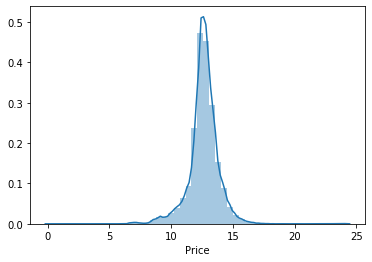

In [35]:
sns.distplot(np.log(data.Price[(data.Price >0)&(data.Price <=34500126672.528)]))

In [36]:
#get rid of exceptions data
data.drop(data.Price[(data.Price <=0)|(data.Price >34500126672.528)].index,axis=0,inplace=True)

In [37]:
#normalizing Price
data.Price=np.log(data.Price)

In [38]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

In [39]:
data=pd.read_csv('dataintermediate.csv')

## Year built and remodeled

In [40]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363979 entries, 0 to 363978
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          324765 non-null  object 
 1   private pool    4151 non-null    object 
 2   baths           267677 non-null  object 
 3   homeFacts       363979 non-null  object 
 4   fireplace       102296 non-null  object 
 5   schools         363979 non-null  object 
 6   sqft            363979 non-null  float64
 7   beds            281183 non-null  object 
 8   state           363979 non-null  object 
 9   stories         224346 non-null  object 
 10  PrivatePool     40001 non-null   object 
 11  propertyType    337103 non-null  object 
 12  Price           363979 non-null  float64
 13  Year built      310114 non-null  object 
 14  Remodeled year  149343 non-null  float64
 15  Heating         264298 non-null  object 
 16  Cooling         250204 non-null  object 
 17  Parking   

In [41]:
#put indexes of str and num values in to variables
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index

In [42]:
#replace exeptions where there is no sence (smaller than 0 or bigger than 2020) by No Data
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<0)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

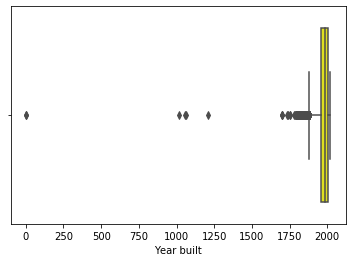

In [43]:
#Check if there are more exeptions
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [44]:
#Drop more exeptions values that smaller than 1500 -> update number indexes value
iyearexp=data['Year built'].iloc[numi].astype('int64')[(data['Year built'].iloc[numi].astype('int64')<1500)|(data['Year built'].iloc[numi].astype('int64')>2020)].index
data['Year built'].iloc[iyearexp]='No Data'
numi=data['Year built'][data['Year built'].str.contains('\D')==False].index
stri=data['Year built'][data['Year built'].str.contains('\D')==True].index

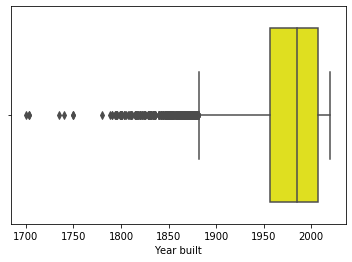

In [45]:
sns.boxplot(data['Year built'].iloc[numi].astype('int64'), color='yellow');

In [46]:
#convert numeric data to integer
data['Year built'].iloc[numi]=data['Year built'].iloc[numi].astype(int)

In [47]:
#replace string data to mean of numeric data
data['Year built'].iloc[stri]=int(round(data['Year built'].iloc[numi].mean(),0))

In [48]:
#fill nas with the mean of numeric values
data['Year built'].fillna(int(round(data['Year built'].iloc[numi].mean(),0)),inplace=True)

In [49]:
data['Year built'].describe()

count    363979.000000
mean       1979.307166
std          30.905259
min        1700.000000
25%        1962.000000
50%        1979.000000
75%        2005.000000
max        2020.000000
Name: Year built, dtype: float64

In [50]:
data['Remodeled year'].fillna(data['Remodeled year'].notnull().mean(),inplace=True)
data['Remodeled year']=data['Remodeled year'].astype(int)

### Status

In [51]:
data.status=data.status.str.lower()
status=data.status
status=status.value_counts(normalize=True).reset_index()
status
#according to next summary I would use only for sale, active, accepted for status(that are 91% of overall amount), the rest will be dropped

,index,status
0,for sale,0.607365
1,active,0.298634
2,foreclosure,0.018010
3,new construction,0.016797
4,pending,0.014768
...,...,...
145,pending backups wanted,0.000003
146,coming soon: oct 21.,0.000003
147,coming soon: nov 23.,0.000003
148,coming soon: dec 25.,0.000003


In [52]:
strlist=['for sale','active','accepted']
status['newStatus']=status['index'].apply(lambda x: substringExists(x,strlist))
nstatus=status.groupby('newStatus').sum().reset_index()
nstatus

,newStatus,status
0,1,0.910160
1,/ auction,0.002457
2,accepting backups,0.000006
3,apartment for rent,0.000022
4,auction,0.001490
...,...,...
128,under contract - show,0.000028
129,under contract backups,0.000776
130,under contract show,0.003643
131,under contract taking back up offers,0.000003


In [53]:
#create list of statuses that are not relevant and then drop them from df
nstatus=status[status['newStatus']!=1]['newStatus']
nstatus.tolist()

['foreclosure',
 'new construction',
 'pending',
 'pre-foreclosure',
 'p',
 'pre-foreclosure / auction',
 'under contract show',
 ' / auction',
 'under contract   showing',
 'under contract',
 'new',
 'contingent',
 'price change',
 'auction',
 'for rent',
 'foreclosed',
 'recently sold',
 'under contract backups',
 'contingent finance and inspection',
 'pending continue to show',
 'back on market',
 'option pending',
 'contingent show',
 'pending taking backups',
 'option contract',
 'pending with contingencies',
 'c',
 'pi',
 'contract p',
 'p pending sale',
 'due diligence period',
 'contract contingent on buyer sale',
 'listing extended',
 'c continue show',
 'pending - taking backups',
 'closed',
 'offer pending signature',
 'contingent take backup',
 'pending inspection',
 'pending in',
 'contingent   show',
 'u under contract',
 'coming soon: nov 29.',
 'contingent escape',
 'pending w/insp finance',
 'under contract - show',
 'contingency contract',
 'ct insp - inspection conti

In [54]:
data.drop(data[data['status'].isin(nstatus)==True].index.values.tolist(),inplace=True)
data=data.reset_index()
data.drop(['index'],axis=1,inplace=True)
data.drop(['status'],axis=1,inplace=True)
data.head()

,private pool,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,NaN,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2.900000e+03,4,NC,NaN,NaN,Single Family Home,12.942279,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,NaN,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1.947000e+03,3 Beds,WA,2.0,NaN,single-family home,12.642949,2019,0,NaN,NaN,NaN,4
2,NaN,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3.000000e+03,3 Beds,CA,1.0,yes,single-family home,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,NaN,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6.457000e+03,5 Beds,TX,3.0,NaN,single-family home,14.689122,2006,2006,Forced Air,Central,Detached Garage,10
4,NaN,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",4.364280e+08,NaN,FL,NaN,NaN,lot/land,8.517193,1979,0,NaN,NaN,NaN,5


### Private Pool

In [55]:
data['PrivatePool']=data['PrivatePool'].str.lower()
data['private pool']=data['private pool'].str.lower()

In [56]:
# Replace 'yes' with 1 and unufy "private pool" and PrivatePool and replace NA with 0
data[['private pool','PrivatePool']]=data[['private pool','PrivatePool']].replace(to_replace=['yes'],value=1)
data['PrivatePool']=data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool']=data['PrivatePool'].fillna(0)
data=data.drop(['private pool'],axis=1)


In [57]:
data.PrivatePool=data.PrivatePool.astype(int)
data.PrivatePool.value_counts()

0    291983
1     42819
Name: PrivatePool, dtype: int64

In [58]:
data.head()

,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,3.5,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2.900000e+03,4,NC,NaN,0,Single Family Home,12.942279,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,3 Baths,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1.947000e+03,3 Beds,WA,2.0,0,single-family home,12.642949,2019,0,NaN,NaN,NaN,4
2,2 Baths,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3.000000e+03,3 Beds,CA,1.0,1,single-family home,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,8 Baths,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6.457000e+03,5 Beds,TX,3.0,0,single-family home,14.689122,2006,2006,Forced Air,Central,Detached Garage,10
4,NaN,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",4.364280e+08,NaN,FL,NaN,0,lot/land,8.517193,1979,0,NaN,NaN,NaN,5


### Bath

In [59]:
data.baths=data.baths.str.lower()
print(f'There are {round(data.baths.isna().sum()/data.baths.count()*100,0)}% missing values')

There are 38.0% missing values


In [60]:
#Leave cells with numbers only for Bath 
data['baths']=data.baths.str.findall(r'\d').str[0]

In [61]:
data['baths'][data.baths.isna()==False]=data['baths'][data.baths.isna()==False].astype(int)

In [62]:
data.baths.value_counts(normalize=True)

2.0    0.437617
3.0    0.274373
4.0    0.107001
1.0    0.093303
5.0    0.038817
6.0    0.017567
0.0    0.014930
7.0    0.009527
8.0    0.004650
9.0    0.002215
Name: baths, dtype: float64

In [63]:
#Group data according to property type and take the average bathrooms for each property type for NA
Baths=data[['baths','propertyType']]
Baths['baths']=Baths['baths'][Baths.baths.isna()==False].astype(int)
Baths=Baths[Baths.baths.isna()==False].groupby(by='propertyType').mean().reset_index()
Baths.baths=Baths.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(Baths, on='propertyType', how='left').baths_y
data.head()

,baths,homeFacts,fireplace,schools,sqft,beds,state,stories,PrivatePool,propertyType,Price,Year built,Remodeled year,Heating,Cooling,Parking,schRating
0,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",Gas Logs,"{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR...",2.900000e+03,4,NC,NaN,0,Single Family Home,12.942279,2019,0,"Central A/C, Heat Pump",NaN,NaN,7
1,3,"[{'factValue': '2019', 'factLabel': 'Year buil...",NaN,"{'rating': ['4/10', 'None/10', '4/10'], 'data'...",1.947000e+03,3 Beds,WA,2.0,0,single-family home,12.642949,2019,0,NaN,NaN,NaN,4
2,2,"[{'factValue': '1961', 'factLabel': 'Year buil...",yes,"{'rating': ['8/10', '4/10', '8/10'], 'data': {...",3.000000e+03,3 Beds,CA,1.0,1,single-family home,14.878496,1961,1967,Forced Air,Central,Attached Garage,8
3,8,"[{'factValue': '2006', 'factLabel': 'Year buil...",yes,"{'rating': ['9/10', '9/10', '10/10', '9/10'], ...",6.457000e+03,5 Beds,TX,3.0,0,single-family home,14.689122,2006,2006,Forced Air,Central,Detached Garage,10
4,2,"[{'factValue': '', 'factLabel': 'Year built'},...",NaN,"{'rating': ['4/10', '5/10', '5/10'], 'data': {...",4.364280e+08,NaN,FL,NaN,0,lot/land,8.517193,1979,0,NaN,NaN,NaN,5


In [64]:
#Group data according to bedrooms and take the average bathrooms for each bedroom number for NA
BathsBeds=data[['baths','beds']]
BathsBeds['baths']=BathsBeds['baths'][BathsBeds.baths.isna()==False].astype(int)
BathsBeds=BathsBeds[BathsBeds.baths.isna()==False].groupby(by='beds').mean().reset_index()
BathsBeds.baths=BathsBeds.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsBeds, on='beds', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334802 entries, 0 to 334801
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           262389 non-null  object 
 1   homeFacts       334802 non-null  object 
 2   fireplace       93464 non-null   object 
 3   schools         334802 non-null  object 
 4   sqft            334802 non-null  float64
 5   beds            254423 non-null  object 
 6   state           334802 non-null  object 
 7   stories         204703 non-null  object 
 8   PrivatePool     334802 non-null  int32  
 9   propertyType    308191 non-null  object 
 10  Price           334802 non-null  float64
 11  Year built      334802 non-null  int64  
 12  Remodeled year  334802 non-null  int32  
 13  Heating         243258 non-null  object 
 14  Cooling         231734 non-null  object 
 15  Parking         181640 non-null  object 
 16  schRating       334802 non-null  int64  
dtypes: float64

In [65]:
#check if some values can be taken from beds column
data['beds'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]

197        Bath
2022      Baths
2259       Bath
2911      Baths
3790      Baths
          ...  
333283    Baths
333485    Baths
334024    Baths
334165    Baths
334314    Baths
Name: beds, Length: 866, dtype: object

In [66]:
#beds columns has values that contains baths, replace NA with 1 for bath and 2 for baths
data['beds'][(data.beds=='Bath')&(data.beds.isna()==False)&(data.baths.isna()==True)]=1
data['beds'][(data.beds=='Baths')&(data.beds.isna()==False)&(data.baths.isna()==True)]=2
data['baths'][(data.beds.str.contains('Bath'))&(data.beds.isna()==False)&(data.baths.isna()==True)]=1

In [67]:
#Group data according to sqft and take the average bathrooms for each area for NA
BathsArea=data[['baths','sqft']]
BathsArea['baths']=BathsArea['baths'][BathsArea.baths.isna()==False].astype(int)
BathsArea=BathsArea[BathsArea.baths.isna()==False].groupby(by='sqft').mean().reset_index()
BathsArea.baths=BathsArea.baths.round(decimals=0)
data.baths[data.baths.isna()==True]=data[data.baths.isna()==True].merge(BathsArea, on='sqft', how='left').baths_y
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334802 entries, 0 to 334801
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           266060 non-null  object 
 1   homeFacts       334802 non-null  object 
 2   fireplace       93464 non-null   object 
 3   schools         334802 non-null  object 
 4   sqft            334802 non-null  float64
 5   beds            254423 non-null  object 
 6   state           334802 non-null  object 
 7   stories         204703 non-null  object 
 8   PrivatePool     334802 non-null  int32  
 9   propertyType    308191 non-null  object 
 10  Price           334802 non-null  float64
 11  Year built      334802 non-null  int64  
 12  Remodeled year  334802 non-null  int32  
 13  Heating         243258 non-null  object 
 14  Cooling         231734 non-null  object 
 15  Parking         181640 non-null  object 
 16  schRating       334802 non-null  int64  
dtypes: float64

In [68]:
data.baths.fillna(1,inplace=True)
data.baths=data.baths.astype(int)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334802 entries, 0 to 334801
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334802 non-null  int32  
 1   homeFacts       334802 non-null  object 
 2   fireplace       93464 non-null   object 
 3   schools         334802 non-null  object 
 4   sqft            334802 non-null  float64
 5   beds            254423 non-null  object 
 6   state           334802 non-null  object 
 7   stories         204703 non-null  object 
 8   PrivatePool     334802 non-null  int32  
 9   propertyType    308191 non-null  object 
 10  Price           334802 non-null  float64
 11  Year built      334802 non-null  int64  
 12  Remodeled year  334802 non-null  int32  
 13  Heating         243258 non-null  object 
 14  Cooling         231734 non-null  object 
 15  Parking         181640 non-null  object 
 16  schRating       334802 non-null  int64  
dtypes: float64

### Beds

In [70]:
data.beds=data.beds.str.lower()
print(f'There are {round(data.beds.isna().sum()/data.baths.count()*100,0)}% of missing values')

There are 24.0% of missing values


In [71]:
data.beds.value_counts(normalize=True)

3 beds                0.197075
4 beds                0.133533
3                     0.108368
2 beds                0.097431
4                     0.069801
                        ...   
3 or more bedrooms    0.000004
39 beds               0.000004
2.57 acres            0.000004
2.09 acres            0.000004
23.39 acres           0.000004
Name: beds, Length: 581, dtype: float64

In [72]:
#leave numbers only for Beds
data['beds']=data.beds.str.replace(' beds','').str.replace(' bd','')
data['beds']=data.beds.str.replace('baths','2')
data['beds']=data.beds.str.replace('bath','1')
data.beds[(data.beds.str.contains('\D')==True)&(data.beds.isna()==False)].value_counts(normalize=True)

3.0            0.342670
4.0            0.231472
2.0            0.105428
none           0.075402
5.0            0.062237
                 ...   
3.7 acres      0.000056
16.57 acres    0.000056
2.46 acres     0.000056
11.2 acres     0.000056
12.97 acres    0.000056
Name: beds, Length: 469, dtype: float64

In [73]:
data['beds'][data.beds.str.contains('sqft|acres|acre| |--')==True]=0


In [74]:
data['beds'][data.beds.str.contains('2 bedrooms')==True]=2
data['beds'][data.beds.str.contains('3 or more bedrooms')==True]=3
data['beds'][data.beds.str.contains('based on redfin')==True]=1

In [75]:
data['beds']=data['beds'][(data.beds.isna()==False)&(data.beds!='none')].astype(float)


In [76]:
#Group data according to property type and take the average area for each property type for NA
Beds=data[['beds','propertyType']]
Beds['beds']=Beds['beds'][(Beds.beds.isna()==False)&(Beds.beds!='none')].astype(float)
Beds=Beds.groupby(by='propertyType').mean().reset_index()
Beds.beds=Beds.beds.round(decimals=0)
data=data.merge(Beds, on='propertyType', how='left')

In [77]:
data['beds_x'].fillna(data.beds_y,inplace=True)
data['beds_x'][data.beds_x=='none']=data.beds_y
data.beds_x.fillna(data.beds_x.mean(),inplace=True)
data.drop('beds_y',axis=1,inplace=True)
data=data.rename(columns={'beds_x':'beds'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334802 entries, 0 to 334801
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334802 non-null  int32  
 1   homeFacts       334802 non-null  object 
 2   fireplace       93464 non-null   object 
 3   schools         334802 non-null  object 
 4   sqft            334802 non-null  float64
 5   beds            334802 non-null  float64
 6   state           334802 non-null  object 
 7   stories         204703 non-null  object 
 8   PrivatePool     334802 non-null  int32  
 9   propertyType    308191 non-null  object 
 10  Price           334802 non-null  float64
 11  Year built      334802 non-null  int64  
 12  Remodeled year  334802 non-null  int32  
 13  Heating         243258 non-null  object 
 14  Cooling         231734 non-null  object 
 15  Parking         181640 non-null  object 
 16  schRating       334802 non-null  int64  
dtypes: float64

In [78]:
data.beds.value_counts(normalize=True,bins=10)

(-0.145, 14.4]    0.999044
(14.4, 28.8]      0.000678
(57.6, 72.0]      0.000131
(28.8, 43.2]      0.000093
(43.2, 57.6]      0.000033
(72.0, 86.4]      0.000012
(86.4, 100.8]     0.000006
(129.6, 144.0]    0.000003
(115.2, 129.6]    0.000000
(100.8, 115.2]    0.000000
Name: beds, dtype: float64

In [79]:
data=data.drop(data.beds[data.beds>15].index)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334514 entries, 0 to 334801
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334514 non-null  int32  
 1   homeFacts       334514 non-null  object 
 2   fireplace       93435 non-null   object 
 3   schools         334514 non-null  object 
 4   sqft            334514 non-null  float64
 5   beds            334514 non-null  float64
 6   state           334514 non-null  object 
 7   stories         204572 non-null  object 
 8   PrivatePool     334514 non-null  int32  
 9   propertyType    307903 non-null  object 
 10  Price           334514 non-null  float64
 11  Year built      334514 non-null  int64  
 12  Remodeled year  334514 non-null  int32  
 13  Heating         243095 non-null  object 
 14  Cooling         231601 non-null  object 
 15  Parking         181485 non-null  object 
 16  schRating       334514 non-null  int64  
dtypes: float64

### Create feature baths per bedroom

In [81]:
data['baths'][data['baths']<1]=1
data['beds'][data['beds']<1]=1
data['baths/bed']=data['beds']/data['baths']

In [82]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)

### Fireplace

In [83]:
data=pd.read_csv('dataintermediate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334514 entries, 0 to 334513
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334514 non-null  int64  
 1   homeFacts       334514 non-null  object 
 2   fireplace       93435 non-null   object 
 3   schools         334514 non-null  object 
 4   sqft            334514 non-null  float64
 5   beds            334514 non-null  float64
 6   state           334514 non-null  object 
 7   stories         204572 non-null  object 
 8   PrivatePool     334514 non-null  int64  
 9   propertyType    307903 non-null  object 
 10  Price           334514 non-null  float64
 11  Year built      334514 non-null  int64  
 12  Remodeled year  334514 non-null  int64  
 13  Heating         243095 non-null  object 
 14  Cooling         231601 non-null  object 
 15  Parking         181485 non-null  object 
 16  schRating       334514 non-null  int64  
 17  baths/bed 

In [84]:
data['fireplace']=data['fireplace'].str.lower()
data.fireplace[data.fireplace.str.contains('fire|yes|gas|burning|stove|frplc')==True]=1
data.fireplace[data.fireplace.str.contains('no|0 ')==True]=0
data.fireplace[(data.fireplace.str.contains('\d')==True)&(data.fireplace.str.contains('0')==False)]=1
data.fireplace[data.fireplace!=1]=0

In [85]:
data.fireplace=data.fireplace.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334514 entries, 0 to 334513
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   baths           334514 non-null  int64  
 1   homeFacts       334514 non-null  object 
 2   fireplace       334514 non-null  int32  
 3   schools         334514 non-null  object 
 4   sqft            334514 non-null  float64
 5   beds            334514 non-null  float64
 6   state           334514 non-null  object 
 7   stories         204572 non-null  object 
 8   PrivatePool     334514 non-null  int64  
 9   propertyType    307903 non-null  object 
 10  Price           334514 non-null  float64
 11  Year built      334514 non-null  int64  
 12  Remodeled year  334514 non-null  int64  
 13  Heating         243095 non-null  object 
 14  Cooling         231601 non-null  object 
 15  Parking         181485 non-null  object 
 16  schRating       334514 non-null  int64  
 17  baths/bed 

### Stories

In [86]:
data.stories=data.stories.str.lower()

In [87]:
data['st1']=data.stories.str.findall(r'\d').str[0]
#data.stories=data.stories[data.st1.isna()==False]
data.stories[(data.st1.isna()==True)&(data.stories.isna()==False)].value_counts()
#data.stories.value_counts()

one                           5462
two                           2426
three or more                  542
lot                            303
one story                      297
                              ... 
two, multi/split                 1
co-op                            1
quad level                       1
bedroom - split plan             1
multi-level, new englander       1
Name: stories, Length: 92, dtype: int64

In [88]:
data.stories[data.stories.str.contains('one')==True]=1
data.stories[data.stories.str.contains('two')==True]=2

In [89]:
data.stories=data['st1'][(data.st1.isna()==False)&(data.stories.isna()==False)]

In [90]:
data.drop('st1',axis=1,inplace=True)
data.dropna(subset=['stories'],axis=0,inplace=True)

In [91]:
data.stories=data.stories.astype(int)

In [92]:
data['stories'][data.stories<2]=1
data['stories'][data.stories>1]=2

In [93]:
data.stories.value_counts()

2    97242
1    96399
Name: stories, dtype: int64

In [94]:
#data.to_csv('dataintermediate.csv',index=False)
saveData(data)


### Parking

In [95]:
data=pd.read_csv('dataintermediate.csv')
data.Parking.value_counts()

Attached Garage                                                                                                                             52305
2 spaces                                                                                                                                    21504
1 space                                                                                                                                     10357
No Data                                                                                                                                      9049
Detached Garage                                                                                                                              8290
                                                                                                                                            ...  
Attached, On Street                                                                                                         

In [96]:
data.Parking[data.Parking.notnull()==True]=data.Parking[data.Parking.notnull()==True].str.lower()
data.Parking[(data.Parking.notnull()==True)&(data.Parking.str.contains('no')==True)]=0
data.Parking[(data.Parking.notnull()==True)]=1


In [97]:
data.Parking.fillna(0,inplace=True)
data.Parking.astype(int)

0         0
1         1
2         1
3         0
4         1
         ..
193636    1
193637    1
193638    1
193639    1
193640    1
Name: Parking, Length: 193641, dtype: int32

## Density per state- additional data

In [98]:
url = 'https://www.census.gov/data/tables/2010/dec/density-data-text.html'  

In [99]:
pd.read_html(url)[0].to_csv('density2010.csv',index=False)
density=pd.read_csv('density2010.csv')

In [100]:
density2010=pd.DataFrame(density.iloc[3::4]['2010'].values,columns=['statefull'])
density2010['density']=density.iloc[5::4]['2010'].values
density2010.head()

,statefull,density
0,Alabama,94.4
1,Alaska,1.2
2,Arizona,56.3
3,Arkansas,56.0
4,California,239.1


In [101]:
url1 = 'https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations'  
pd.read_html(url1)[0].iloc[11:,[0,3]].dropna().to_csv('abrv.csv',index=False)
stateabrv=pd.read_csv('abrv.csv')
stateabrv.head()

,"Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP)","Codes: ISO ISO 3166 codes (2-letter, 3-letter, and 3-digit codes from ISO 3166-1; 2+2-letter codes from ISO 3166-2) ANSI 2-letter and 2-digit codes from the ANSI standard INCITS 38:2009 (supersedes FIPS 5-2) USPS 2-letter codes used by the United States Postal Service USCG 2-letter codes used by the United States Coast Guard (bold red text shows differences between ANSI and USCG) Abbreviations: GPO Older variable-length official US Government Printing Office abbreviations AP Abbreviations from the AP Stylebook (bold red text shows differences between GPO and AP).3"
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [102]:
stateabrv.columns=['statefull','state']

In [103]:
density2010=density2010.merge(stateabrv, on='statefull', how='left')
density2010.head()

,statefull,density,state
0,Alabama,94.4,AL
1,Alaska,1.2,AK
2,Arizona,56.3,AZ
3,Arkansas,56.0,AR
4,California,239.1,CA


In [104]:
data.state=data.state.astype(str)

In [105]:
data.state

0         WA
1         CA
2         TX
3         PA
4         TX
          ..
193636    DC
193637    FL
193638    IL
193639    NY
193640    TX
Name: state, Length: 193641, dtype: object

In [106]:
data=data.merge(density2010, on='state', how='left')

In [107]:
data.density=data.density.astype(float)

## Features table

In [108]:
Features=data[['stories','fireplace','sqft','PrivatePool','Year built','Remodeled year','baths/bed','Parking','schRating','density']]
target=data.Price

In [109]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193641 entries, 0 to 193640
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         193641 non-null  int64  
 1   fireplace       193641 non-null  int64  
 2   sqft            193641 non-null  float64
 3   PrivatePool     193641 non-null  int64  
 4   Year built      193641 non-null  int64  
 5   Remodeled year  193641 non-null  int64  
 6   baths/bed       193641 non-null  float64
 7   Parking         193641 non-null  int64  
 8   schRating       193641 non-null  int64  
 9   density         193641 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 16.3 MB


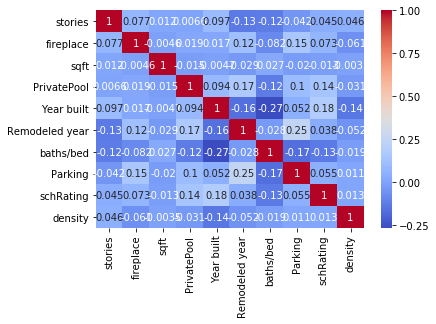

In [110]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')

# Model

In [111]:
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [112]:
scaler = StandardScaler()
FeaturesSt=scaler.fit_transform(Features)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (154912, 10)
X_test: (38729, 10)
y_train: (154912,)
y_test: (38729,)


In [114]:
start = timer()
predictor = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.4)
predictor.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
end = timer()
print(end - start)

154.40003839999997


In [115]:
mae=mean_absolute_error(y_test,y_pred)
mse=mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(X_test,y_test),4)}, MAE GB: {round(mae,2)}, RSME: {round(np.sqrt(mse),2)}')


R^2 GB: 0.7165, MAE GB: 0.34, RSME: 0.5


The model is not perfect and requires some further work with the data. 